In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn

from sklearn.model_selection import train_test_split 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression ,Ridge #  LinearRegression, Ridge 예측, LogisticRegression 분류

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, SVR #분류/예측

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN

from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 


from sklearn.tree import export_graphviz
import graphviz
import os
os.environ['PATH'] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

1. stock market prediction > regression
   input : 한국 KOSPI + 미국 DJIA 검색
   output : KOSPI 미래의 1개월간(1일)의 종가 예측
   - KOSPI : https://finance.naver.com/sise/sise_index_day.nhn?code=KOSPI&page=##
   - DJIA : https://finance.yahoo.com/quote/%5EDJI/history?period1=1531810422&period2=1563346422&interval=1d&filter=history&frequency=1d
   - 2018.07.17 ~ 현재까지 1년치 데이터 사용

In [96]:
kospi_url='https://finance.naver.com/sise/sise_index_day.nhn?code=KOSPI&page='

In [97]:
tables = pd.read_html(kospi_url+'1')
tables[0]

,날짜,체결가,전일비,등락률,거래량(천주),거래대금(백만)
0,NaN,NaN,NaN,NaN,NaN,NaN
1,2019.07.17,2072.92,18.95,-0.91%,752119.0,4549215.0
2,2019.07.16,2091.87,9.39,+0.45%,674500.0,5158374.0
3,2019.07.15,2082.48,4.18,-0.20%,455075.0,3656611.0
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,2019.07.12,2086.66,6.08,+0.29%,398353.0,3714594.0
9,2019.07.11,2080.58,21.80,+1.06%,368242.0,4934006.0


In [114]:
kospis = []
max_num = 42
for i in range(1,max_num):
    tables = pd.read_html(kospi_url+str(i))
    kospi = tables[0]
    kospis.append(kospi)
len(kospis)

41

In [115]:
kospi = pd.concat(kospis, axis=0)
kospi.shape

(533, 6)

In [116]:
kospi.tail(10)

,날짜,체결가,전일비,등락률,거래량(천주),거래대금(백만)
3,2018.07.20,2289.19,6.90,+0.30%,346880.0,4839036.0
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,2018.07.19,2282.29,7.82,-0.34%,458752.0,5346881.0
9,2018.07.18,2290.11,7.81,-0.34%,395774.0,4838320.0
10,2018.07.17,2297.92,4.07,-0.18%,365351.0,4696497.0
11,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
kospi = kospi.set_index('날짜')

In [118]:
djia_url = 'https://finance.yahoo.com/quote/%5EDJI/history?period1=1531810422&period2=1563346422&interval=1d&filter=history&frequency=1d'

In [119]:
tables = pd.read_html(djia_url)
len(tables)

1

In [123]:
tables[0].head(), tables[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 7 columns):
Date           101 non-null object
Open           101 non-null object
High           101 non-null object
Low            101 non-null object
Close*         101 non-null object
Adj Close**    101 non-null object
Volume         101 non-null object
dtypes: object(7)
memory usage: 5.6+ KB


(           Date      Open      High       Low    Close* Adj Close**     Volume
 0  Jul 16, 2019  27349.32  27398.68  27290.24  27335.63    27335.63  223850000
 1  Jul 15, 2019  27364.69  27364.69  27294.17  27359.16    27359.16  199730000
 2  Jul 12, 2019  27139.49  27333.79  27135.45  27332.03    27332.03  248390000
 3  Jul 11, 2019  26950.16  27088.45  26916.32  27088.08    27088.08  252300000
 4  Jul 10, 2019  26851.96  26983.45  26813.11  26860.20    26860.20  207990000,
 None)

In [127]:
djia=tables[0]

In [128]:
djia = djia.set_index('Date')

In [130]:
kospi.index, djia.index

(Index([         nan, '2019.07.17', '2019.07.16', '2019.07.15',          nan,
                 nan,          nan,          nan, '2019.07.12', '2019.07.11',
        ...
        '2018.07.20',          nan,          nan,          nan,          nan,
        '2018.07.19', '2018.07.18', '2018.07.17',          nan,          nan],
       dtype='object', name='날짜', length=533),
 Index(['Jul 16, 2019', 'Jul 15, 2019', 'Jul 12, 2019', 'Jul 11, 2019',
        'Jul 10, 2019', 'Jul 09, 2019', 'Jul 08, 2019', 'Jul 05, 2019',
        'Jul 03, 2019', 'Jul 02, 2019',
        ...
        'Mar 06, 2019', 'Mar 05, 2019', 'Mar 04, 2019', 'Mar 01, 2019',
        'Feb 28, 2019', 'Feb 27, 2019', 'Feb 26, 2019', 'Feb 25, 2019',
        'Feb 22, 2019',
        '*Close price adjusted for splits.**Adjusted close price adjusted for both dividends and splits.'],
       dtype='object', name='Date', length=101))

2. loan default prediction > classfication
   input : 검색
   - bank 예제 사용

In [46]:
df = pd.read_csv('bank/bank.csv',sep=';')

In [48]:
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null object
dtypes: int64(7), object(10)
memory usage: 600.5+ KB


(   age          job  marital  education default  balance housing loan  \
 0   30   unemployed  married    primary      no     1787      no   no   
 1   33     services  married  secondary      no     4789     yes  yes   
 2   35   management   single   tertiary      no     1350     yes   no   
 3   30   management  married   tertiary      no     1476     yes  yes   
 4   59  blue-collar  married  secondary      no        0     yes   no   
 
     contact  day month  duration  campaign  pdays  previous poutcome   y  
 0  cellular   19   oct        79         1     -1         0  unknown  no  
 1  cellular   11   may       220         1    339         4  failure  no  
 2  cellular   16   apr       185         1    330         1  failure  no  
 3   unknown    3   jun       199         4     -1         0  unknown  no  
 4   unknown    5   may       226         1     -1         0  unknown  no  ,
 None)

In [49]:
df.isna().sum().sum()

0

In [50]:
# EDM
j= df['job']
j.value_counts()

management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64

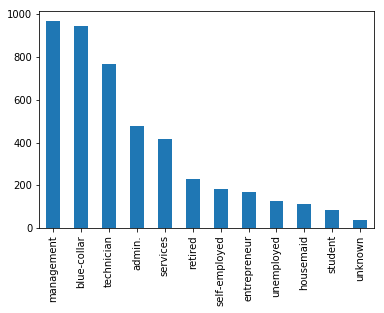

In [51]:
j.value_counts().plot.bar()

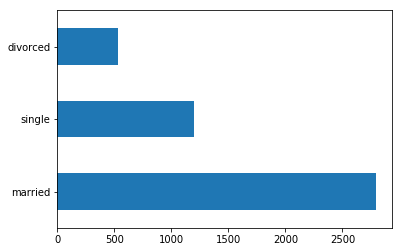

In [52]:
df.marital.value_counts().plot.barh()

In [53]:
(df['y']=='yes').mean()

0.11523999115239991

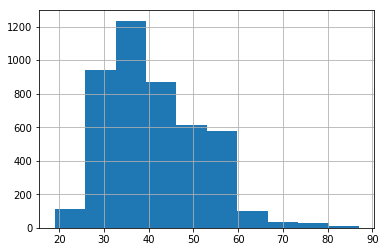

In [54]:
df['age'].hist()

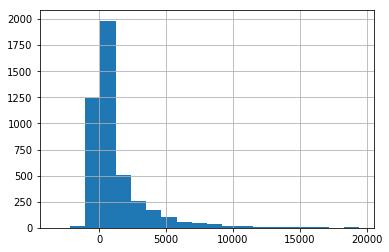

In [55]:
df[df.balance <20000].balance.hist(bins=20)

In [57]:
df2 = df.iloc[:,:-1]

In [59]:
# 원핫 인코딩 준비
# day는 int가 아닌 object여야 한다.
df2['day'] = df2['day'].astype('object')
df2.head(), df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 16 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null object
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
dtypes: int64(6), object(10)
memory usage: 565.2+ KB


(   age          job  marital  education default  balance housing loan  \
 0   30   unemployed  married    primary      no     1787      no   no   
 1   33     services  married  secondary      no     4789     yes  yes   
 2   35   management   single   tertiary      no     1350     yes   no   
 3   30   management  married   tertiary      no     1476     yes  yes   
 4   59  blue-collar  married  secondary      no        0     yes   no   
 
     contact day month  duration  campaign  pdays  previous poutcome  
 0  cellular  19   oct        79         1     -1         0  unknown  
 1  cellular  11   may       220         1    339         4  failure  
 2  cellular  16   apr       185         1    330         1  failure  
 3   unknown   3   jun       199         4     -1         0  unknown  
 4   unknown   5   may       226         1     -1         0  unknown  , None)

In [60]:
df_hot = pd.get_dummies(df2)

In [61]:
#원 핫 인코딩
df_hot = pd.get_dummies(df2)

In [62]:
df_hot.columns

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'month_apr', 'month_aug', 'month_dec', 'month_f

In [63]:
X = df_hot
y = df.iloc[:,-1]
X.head(), y.head()

(   age  balance  duration  campaign  pdays  previous  job_admin.  \
 0   30     1787        79         1     -1         0           0   
 1   33     4789       220         1    339         4           0   
 2   35     1350       185         1    330         1           0   
 3   30     1476       199         4     -1         0           0   
 4   59        0       226         1     -1         0           0   
 
    job_blue-collar  job_entrepreneur  job_housemaid  ...  month_jun  \
 0                0                 0              0  ...          0   
 1                0                 0              0  ...          0   
 2                0                 0              0  ...          0   
 3                0                 0              0  ...          1   
 4                1                 0              0  ...          0   
 
    month_mar  month_may  month_nov  month_oct  month_sep  poutcome_failure  \
 0          0          0          0          1          0              

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state=42) # test_size = 0.25, random_state=42

In [65]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3390, 81), (1131, 81), (3390,), (1131,))

In [66]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.883289124668435

In [69]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr.score(X_test, y_test)

C:\Users\wtime\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8983200707338639

In [70]:
model = DecisionTreeClassifier(max_depth=3).fit(X_train,y_train)
model.score(X_test, y_test)

0.8983200707338639

In [71]:
rf = RandomForestClassifier(n_estimators=100).fit(X_train,y_train)
rf.score(X_test,y_test)

0.900972590627763

In [72]:
rf.feature_importances_, df.columns

(array([0.08638377, 0.0773273 , 0.22646908, 0.03518881, 0.03344908,
        0.02318499, 0.00860278, 0.00946186, 0.00275285, 0.00378379,
        0.01038516, 0.00866171, 0.00474029, 0.00631562, 0.0047766 ,
        0.01005696, 0.00207279, 0.00183145, 0.00898092, 0.01216009,
        0.01083433, 0.00788937, 0.01244366, 0.01339719, 0.00508208,
        0.00233771, 0.00221025, 0.01277277, 0.01411869, 0.00674793,
        0.0061063 , 0.00986139, 0.00497111, 0.00744562, 0.00389054,
        0.00447422, 0.00419398, 0.00188122, 0.00725704, 0.00457657,
        0.00401294, 0.00397638, 0.00474866, 0.00362915, 0.0037553 ,
        0.00666227, 0.00544589, 0.0053613 , 0.0060589 , 0.00797368,
        0.00497959, 0.00678052, 0.003157  , 0.0046065 , 0.00608545,
        0.00433572, 0.00289509, 0.00243063, 0.00253995, 0.00412099,
        0.00426064, 0.00370416, 0.00261407, 0.00807667, 0.00110569,
        0.01245541, 0.00943914, 0.00269584, 0.00618556, 0.00315537,
        0.00824   , 0.01143249, 0.01203668, 0.01

<BarContainer object of 81 artists>

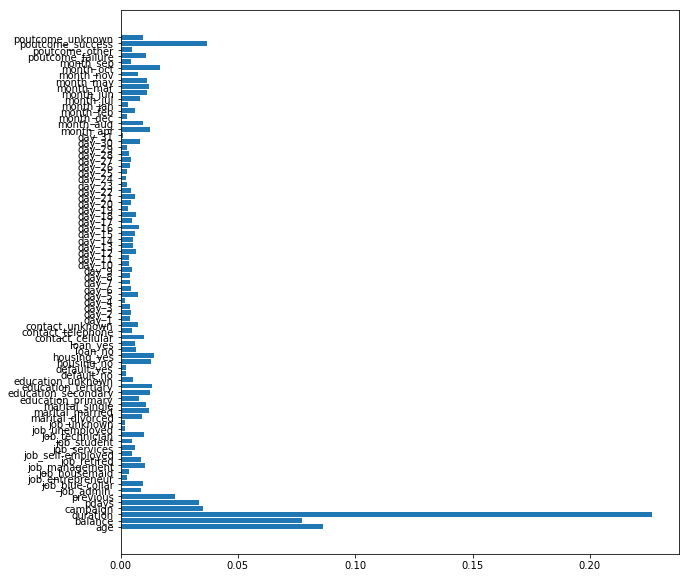

In [75]:
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, rf.feature_importances_)

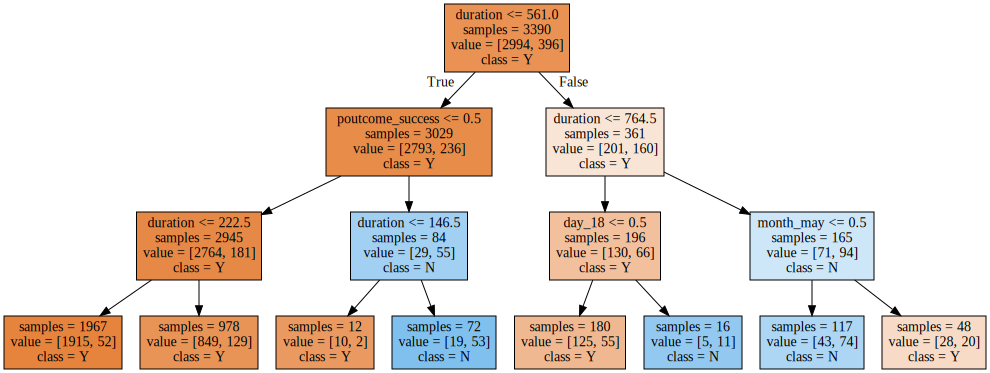

In [74]:
export_graphviz(model, out_file='loan.dot', class_names=['Y','N'], feature_names=X.columns, impurity=False, filled=True)
with open('loan.dot') as f:
    dot_graph = f.read()
g = graphviz.Source(dot_graph)
display(g)

3. credit card froud detection > clustering
   input : 검색
   - https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3
   - v1 ~ v28은 민감정보로 보여짐..
   - may be result of a PCA Dimensionality reduction to protect user identities and sensitive features(v1-v28)

In [7]:
folder = 'creditcardfraud/'
file = 'creditcard.csv'

In [8]:
fraud = pd.read_csv(folder + file)

In [10]:
fraud.head(), fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

(   Time        V1        V2        V3        V4        V5        V6        V7  \
 0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
          V8        V9  ...       V21       V22       V23       V24       V25  \
 0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
 1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
 2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
 3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
 4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   
 
         V26      

In [11]:
# 데이터가 많아 일단 10000개로만
fraud = fraud.iloc[:10000]

In [18]:
fraud.info(), fraud.tail(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
Time      10000 non-null float64
V1        10000 non-null float64
V2        10000 non-null float64
V3        10000 non-null float64
V4        10000 non-null float64
V5        10000 non-null float64
V6        10000 non-null float64
V7        10000 non-null float64
V8        10000 non-null float64
V9        10000 non-null float64
V10       10000 non-null float64
V11       10000 non-null float64
V12       10000 non-null float64
V13       10000 non-null float64
V14       10000 non-null float64
V15       10000 non-null float64
V16       10000 non-null float64
V17       10000 non-null float64
V18       10000 non-null float64
V19       10000 non-null float64
V20       10000 non-null float64
V21       10000 non-null float64
V22       10000 non-null float64
V23       10000 non-null float64
V24       10000 non-null float64
V25       10000 non-null float64
V26       10000 non-null float64
V

(None,
          Time        V1        V2        V3        V4        V5        V6  \
 9980  14940.0  0.509465  1.906159 -2.579983  1.502234  1.395695 -0.798737   
 9981  14941.0 -0.619870  1.077871  1.721085 -0.386582  0.148880 -0.701113   
 9982  14951.0  1.113690  0.761906  1.071124  2.757166 -0.101429 -0.306094   
 9983  14964.0  0.989131 -0.413148  1.213739  0.746907 -0.739761  0.880300   
 9984  14973.0 -1.468494 -0.386998  2.532221  1.455805 -0.779682  0.223008   
 9985  14981.0 -1.372980  1.779108  0.994216  0.290827 -0.849137 -1.171900   
 9986  14988.0 -1.010979  0.956151  2.080257  0.287531 -0.531395  0.303162   
 9987  14989.0 -1.978648  1.866610  0.288459 -0.078206 -0.031190  0.004884   
 9988  14989.0  1.214663  0.637900  0.156007  1.329216  0.216616 -0.842642   
 9989  14989.0  0.973806  0.711426  1.328342  3.790438  0.011453  0.634382   
 9990  14993.0 -0.379366  1.168437 -0.702738  0.566445  1.952919  4.638911   
 9991  14993.0  1.040248  0.288967  1.637475  2.943149 -0

In [13]:
fraud.isna().sum().sum()

0

In [17]:
fraud.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [20]:
fraud2 = fraud.set_index('Time')

In [26]:
fraud2 = fraud2.drop(columns='Class')

In [32]:
fraud2.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [27]:
pca = PCA(n_components=2).fit(fraud2)

In [28]:
x_pca = pca.transform(fraud2)

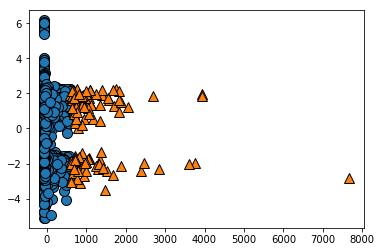

In [29]:
# 1. means
km = KMeans(n_clusters=2).fit(x_pca) # 2개로 그룹화
p1 = km.predict(x_pca)
l = mglearn.discrete_scatter(x_pca[:,0],x_pca[:,1], p1)

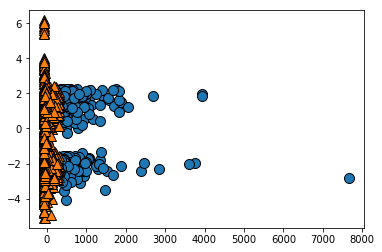

In [34]:
# 2. 병합군집
model1 = AgglomerativeClustering(n_clusters=2)
p2 = model1.fit_predict(x_pca)
l = mglearn.discrete_scatter(x_pca[:,0],x_pca[:,1], p2)

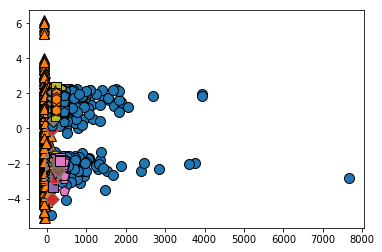

In [38]:
#3. DBSCAN
p3 = DBSCAN(eps=2, min_samples=5).fit_predict(x_pca)
l = mglearn.discrete_scatter(x_pca[:,0],x_pca[:,1], p3)

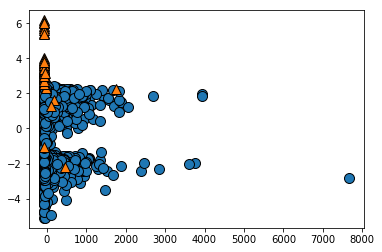

In [39]:
# 정답
l = mglearn.discrete_scatter(x_pca[:,0],x_pca[:,1], fraud.iloc[:,-1])

In [40]:
X = fraud2
y = fraud.iloc[:,-1]
X.head(), y.head()

(            V1        V2        V3        V4        V5        V6        V7  \
 Time                                                                         
 0.0  -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 0.0   1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 1.0  -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 1.0  -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 2.0  -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
             V8        V9       V10  ...       V20       V21       V22  \
 Time                                ...                                 
 0.0   0.098698  0.363787  0.090794  ...  0.251412 -0.018307  0.277838   
 0.0   0.085102 -0.255425 -0.166974  ... -0.069083 -0.225775 -0.638672   
 1.0   0.247676 -1.514654  0.207643  ...  0.524980  0.247998  0.771679   
 1.0   0.377436 -1.387024 -0.054952  ... -0.208038 -0.108300  0.005274   
 

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7500, 29), (2500, 29), (7500,), (2500,))

In [42]:
model = DecisionTreeClassifier(max_depth=5).fit(X_train,y_train)

In [43]:
model.score(X_train, y_train), model.score(X_test, y_test)

(1.0, 0.9996)

<BarContainer object of 29 artists>

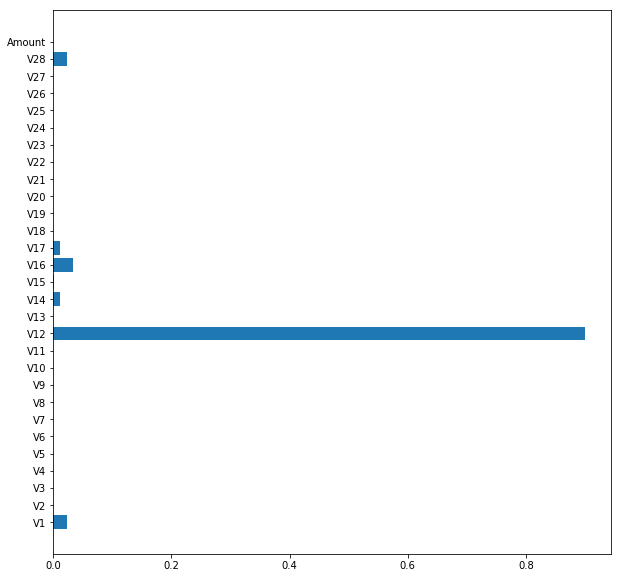

In [44]:
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, model.feature_importances_)